In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import itertools
import time

from routing_v2_proj import Graph, getPaths, shortestPaths, countHops

Number of Nodes:
8
Number of links:
12.0
Average Node Degree:
[3.0]
Network Diameter:
[np.int64(3)]
Average Number of Hops per Demand:
[np.float64(1.8214285714285714)]
Minimum link length:
10.0
Maximum link length:
40.0
Average link length:
17.5
Total Number of Paths:
56
Ordered Paths:
Path: [1, 2] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[1, 2]])
Path: [2, 1] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[2, 1]])
Path: [1, 3] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[1, 3]])
Path: [3, 1] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[3, 1]])
Path: [2, 3] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[2, 3]])
Path: [3, 2] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[3, 2]])
Path: [3, 4] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[3, 4]])
Path: [4, 3] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[4, 3]])
Path: [3, 5] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og. Path: [[3, 5]])
Path: [5, 3] , Dist: 10 , Og.Dist: 10 , traffic = 1 (Og.

In [2]:
G = nx.Graph()

# Dictionary including city names and corresponding numbers
city_dic = {"Norden": 1, "Bremen": 2, "Hamburg": 3, "Hannover": 4, "Berlin": 5, "Leipzig": 6, "Nurnberg": 7, "Munich": 8, "Ulm": 9, "Stuttgart": 10, "Karlsruhe": 11, "Mannheim": 12, "Frankfurt": 13, "Koln": 14, "Dusseldorf": 15, "Essen": 16, "Dortmund": 17}

In [17]:
G_num = nx.Graph() # Graph with city numbers
G_name = nx.Graph() # Graph with city names
G_cap = nx.Graph() # Graph with capacities

distance_factor = 2 # Given parameter

# Populate the graph with nodes
for i in city_dic:
    val = city_dic[i]
    G_num.add_node(val)
    G_name.add_node(i)
    G_cap.add_node(val)

# Remove group specific node (Mannheim)
G_num.remove_node(12)
G_cap.remove_node(12)
G_name.remove_node("Mannheim") 

# Original links from the website
# Tuples include: (source, destination, distance, capacity)
links = [("Munich", "Ulm",120,1), ("Munich", "Nurnberg",150,1), ("Ulm", "Stuttgart",70,1), ("Stuttgart", "Nurnberg",160,1), 
         ("Stuttgart", "Karlsruhe",60,1), ("Karlsruhe", "Mannheim",55,1), ("Mannheim", "Frankfurt",70,1), 
         ("Frankfurt", "Nurnberg",190,1), ("Nurnberg", "Leipzig",230,1), ("Frankfurt", "Leipzig",300,1), ("Frankfurt", "Hannover",265,1),
         ("Frankfurt", "Koln",155,1), ("Koln", "Dusseldorf",35,1), ("Koln", "Dortmund",75,1), ("Dusseldorf", "Essen",30,1),
         ("Essen", "Dortmund",30,1), ("Dortmund", "Hannover",185,1), ("Dortmund", "Norden",230,1), ("Norden", "Bremen",120,1),
         ("Bremen", "Hannover",100,1), ("Bremen", "Hamburg",95,1), ("Hamburg", "Berlin",255,1), ("Berlin", "Leipzig",150,1), ("Berlin", "Hannover",250,1),
         ("Leipzig", "Hannover",215,1), ("Hamburg", "Hannover",130,1)]

# Add links from Karlsruhe to Frankfurt to mitigate the absence of Mannheim
links.append(("Karlsruhe", "Frankfurt",125,1))

# Used cities (names)
names = list(G_name.nodes)

# Add edges to the graph
for i_link in links:
    src = i_link[0]
    dst = i_link[1]
    distance = i_link[2] * distance_factor
    capacity = i_link[3]

    if src in names and dst in names:
        G_name.add_edge(src, dst,length=distance, capacity=capacity)
        G_num.add_edge(city_dic[src], city_dic[dst],length=distance, capacity=capacity)
        G_cap.add_edge(city_dic[src], city_dic[dst],length=distance, load = 0)

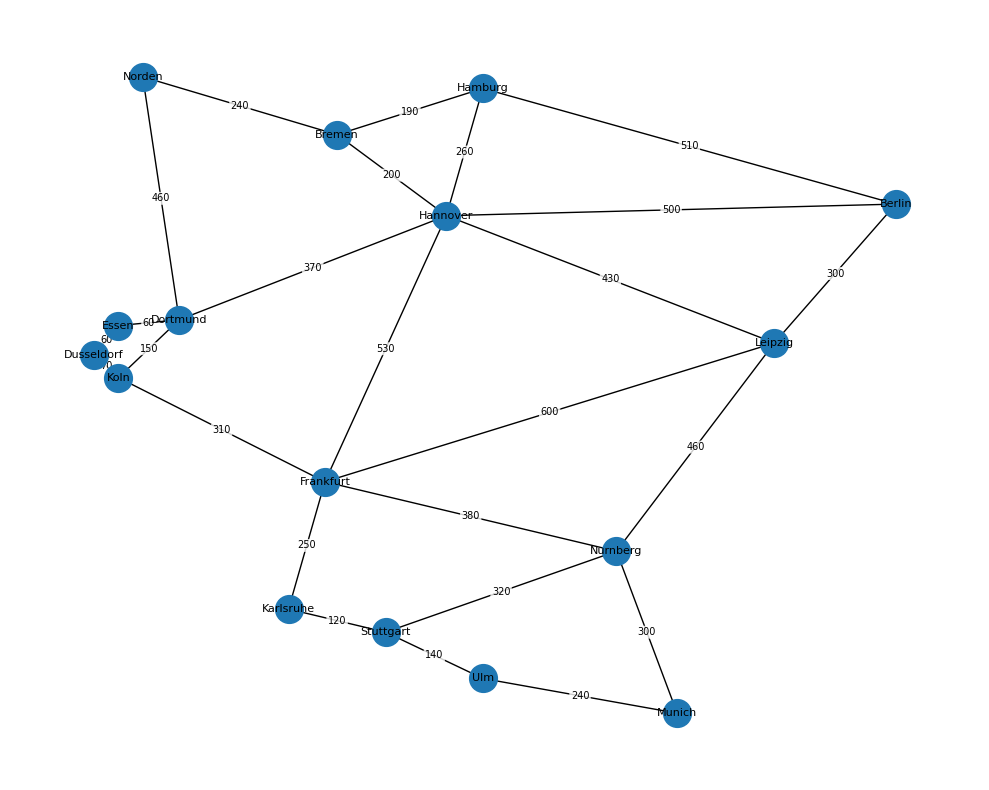

In [18]:
# DRAWING of the graph with city names

 
POS = {
    "Norden": (7.2, 53.6), "Bremen": (8.8, 53.1), "Hamburg": (10.0, 53.5),
    "Hannover": (9.7, 52.4), "Berlin": (13.4, 52.5), "Leipzig": (12.4, 51.3),
    "Nurnberg": (11.1, 49.5), "Munich": (11.6, 48.1), "Ulm": (10.0, 48.4),
    "Stuttgart": (9.2, 48.8), "Karlsruhe": (8.4, 49.0), "Mannheim": (8.5, 49.5),
    "Frankfurt": (8.7, 50.1), "Koln": (7.0, 51.0), "Dusseldorf": (6.8, 51.2),
    "Essen": (7.0, 51.45), "Dortmund": (7.5, 51.5)
}

pos = {city: POS[city] for city in G_name.nodes()}
G_to_draw = G_name

fig, ax = plt.subplots(figsize=(10, 8))

nx.draw_networkx_nodes(G_name, pos, node_size=400)
nx.draw_networkx_edges(G_name, pos, edgelist=G_name.edges, width=1)
nx.draw_networkx_labels(G_name, pos, font_size=8, font_family="sans-serif")

# Edge labels (distances) — keep subtle but readable for a report figure
edge_labels = {(u, v): f"{d.get('length', '')}" for u, v, d in G_to_draw.edges(data=True)}
nx.draw_networkx_edge_labels(
    G_to_draw, pos, edge_labels=edge_labels, ax=ax,
    font_size=7,
    bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.8),
    rotate=False
)

ax.axis('off')
plt.tight_layout()

# Export high-resolution figures for the report
plt.savefig("weighted_graph.png", dpi=300, bbox_inches="tight")
plt.show()


In [5]:
print("#Edges:", G_name.number_of_edges(), "#Nodes:", G_name.number_of_nodes())

#Edges: 25 #Nodes: 16


Max: 6
Min: 2
Avg: 3.125
Var: 1.359375


<BarContainer object of 5 artists>

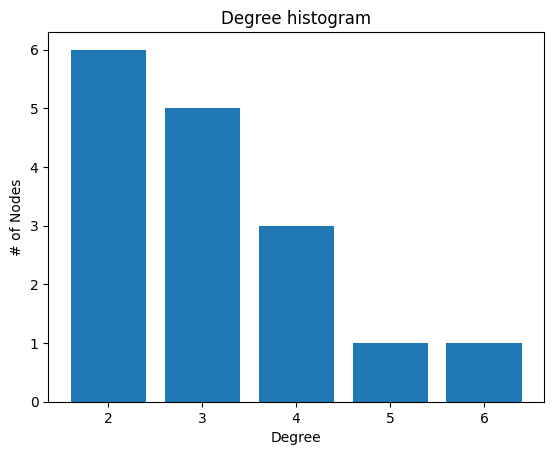

In [6]:
# DEGREE TASKS
degree_sequence = sorted((d for n, d in G_name.degree()), reverse=True)

# max, min, avg, variance
dmax = max(degree_sequence)
dmin = min(degree_sequence)
avg = np.average(degree_sequence)
var = np.var(degree_sequence)

print("Max:", dmax)
print("Min:", dmin)
print("Avg:", avg)
print("Var:", var)

# Distribution of degrees
distr = np.unique(degree_sequence, return_counts=True)

# Histogram
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("# of Nodes")
plt.bar(*distr)

### Part 2

In [7]:
# create adajency matrix for routing_v2_proj.py

node_numbers = sorted(G_num.nodes()) 
n_nodes = len(node_numbers)

num_to_idx = {num: idx for idx, num in enumerate(node_numbers)}
idx_to_num = {idx: num for num, idx in num_to_idx.items()}
num_to_name = {v: k for k, v in city_dic.items() if v != 12}
idx_to_name = {idx: num_to_name[num] for idx, num in idx_to_num.items()}
name_to_idx = {name: idx for idx, name in idx_to_name.items()}

# Weighted adjacency matrix for distances
adj_matrix_weighted = [[0] * n_nodes for _ in range(n_nodes)]

for u, v, data in G_num.edges(data=True):
    i, j = num_to_idx[u], num_to_idx[v]
    adj_matrix_weighted[i][j] = data['length']
    adj_matrix_weighted[j][i] = data['length']

# Unweighted adjacency matrix for hops
adj_matrix_unweighted = [[0] * n_nodes for _ in range(n_nodes)]

for u, v in G_num.edges():
    i, j = num_to_idx[u], num_to_idx[v]
    adj_matrix_unweighted[i][j] = 1
    adj_matrix_unweighted[j][i] = 1

print(f"Created {n_nodes}x{n_nodes} adjacency matrix")
print(f"\nNode mapping (index -> name):")
for idx in range(n_nodes):
    print(f"  {idx+1} -> {idx_to_name[idx]}")
print(f"\nWeighted matrix (first 5 rows):")
for i in range(min(5, n_nodes)):
    print(f"  {idx_to_name[i][:6]:>6}: {adj_matrix_weighted[i][:8]}...")

Created 16x16 adjacency matrix

Node mapping (index -> name):
  1 -> Norden
  2 -> Bremen
  3 -> Hamburg
  4 -> Hannover
  5 -> Berlin
  6 -> Leipzig
  7 -> Nurnberg
  8 -> Munich
  9 -> Ulm
  10 -> Stuttgart
  11 -> Karlsruhe
  12 -> Frankfurt
  13 -> Koln
  14 -> Dusseldorf
  15 -> Essen
  16 -> Dortmund

Weighted matrix (first 5 rows):
  Norden: [0, 240, 0, 0, 0, 0, 0, 0]...
  Bremen: [240, 0, 190, 200, 0, 0, 0, 0]...
  Hambur: [0, 190, 0, 260, 510, 0, 0, 0]...
  Hannov: [0, 200, 260, 0, 500, 430, 0, 0]...
  Berlin: [0, 0, 510, 500, 0, 300, 0, 0]...


In [ ]:
# PHASE 2a: COMPUTE ALL SHORTEST PATHS
graph = Graph()

# Compute shortest paths using weighted matrix
paths_weighted = shortestPaths(graph, adj_matrix_weighted)

# Compute shortest paths using unweighted matrix
paths_unweighted = shortestPaths(graph, adj_matrix_unweighted)

hop_matrix = countHops(paths_unweighted)

print(f"\nComputed paths for {n_nodes} nodes")
print(f"Total node pairs: {n_nodes * (n_nodes-1) // 2}")


Computing shortest paths (weighted - distances)...
Computing shortest paths (unweighted - hops)...

Computed paths for 16 nodes
Total node pairs: 120


In [ ]:
# Display some example paths
print("\nExample shortest path (weighted by distance):")
print("-" * 60)

hamburg_idx = name_to_idx['Hamburg']
dusseldorf_idx = name_to_idx['Dusseldorf']

path_info = paths_weighted[hamburg_idx][dusseldorf_idx]
path_nodes = path_info['path'][0]  
path_names = [idx_to_name[p-1] for p in path_nodes]

print(f"\nHamburg -> Dusseldorf:")
print(f"  Distance: {path_info['distance']} km")
print(f"  Hops: {hop_matrix[hamburg_idx][dusseldorf_idx]}")
print(f"  Path (indices): {path_nodes}")
print(f"  Path (names): {' -> '.join(path_names)}")


Example shortest path (weighted by distance):
------------------------------------------------------------

Hamburg -> Dusseldorf:
  Distance: 750 km
  Hops: 4
  Path (indices): [3, 4, 16, 15, 14]
  Path (names): Hamburg -> Hannover -> Dortmund -> Essen -> Dusseldorf


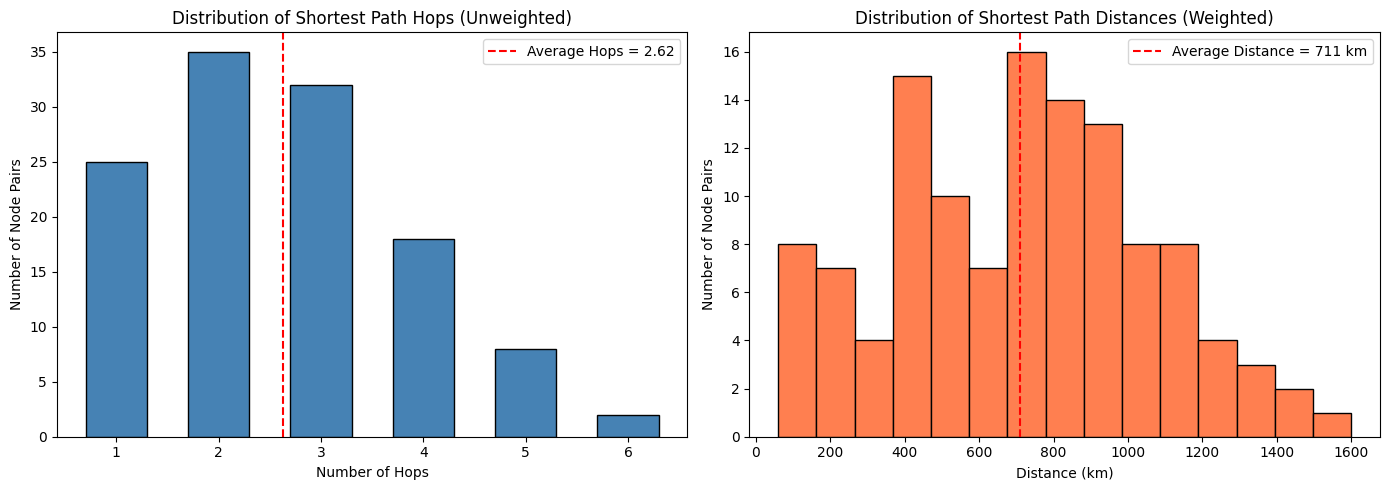


Hop distribution:
  1 hops: 25 pairs (20.8%)
  2 hops: 35 pairs (29.2%)
  3 hops: 32 pairs (26.7%)
  4 hops: 18 pairs (15.0%)
  5 hops: 8 pairs (6.7%)
  6 hops: 2 pairs (1.7%)

Distance statistics:
  Min: 60 km
  Max: 1600 km
  Avg: 711 km


In [929]:
# PHASE 2b: HISTOGRAMS FOR HOPS AND DISTANCES

# Collect all unique distances and hops
all_distances = []
all_hops = []

for i in range(n_nodes):
    for j in range(i+1, n_nodes):
        all_distances.append(paths_weighted[i][j]['distance'])
        all_hops.append(hop_matrix[i][j])

# Create histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hop count histogram
ax1 = axes[0]
unique_hops, hop_counts = np.unique(all_hops, return_counts=True)
ax1.bar(unique_hops, hop_counts, color='steelblue', edgecolor='black', width=0.6)
ax1.set_xlabel('Number of Hops')
ax1.set_ylabel('Number of Node Pairs')
ax1.set_title('Distribution of Shortest Path Hops (Unweighted)')
ax1.set_xticks(unique_hops)
avg_hops = np.mean(all_hops)
ax1.axvline(x=avg_hops, color='red', linestyle='--', label=f'Average Hops = {avg_hops:.2f}')
ax1.legend()

# Distance histogram
ax2 = axes[1]
ax2.hist(all_distances, bins=15, color='coral', edgecolor='black')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Number of Node Pairs')
ax2.set_title('Distribution of Shortest Path Distances (Weighted)')
avg_dist = np.mean(all_distances)
ax2.axvline(x=avg_dist, color='red', linestyle='--', label=f'Average Distance = {avg_dist:.0f} km')
ax2.legend()

plt.tight_layout()
plt.savefig('phase2b_histograms.png', dpi=150)
plt.show()

print("\nHop distribution:")
for h, c in zip(unique_hops, hop_counts):
    print(f"  {h} hops: {c} pairs ({c/len(all_hops)*100:.1f}%)")

print(f"\nDistance statistics:")
print(f"  Min: {min(all_distances):.0f} km")
print(f"  Max: {max(all_distances):.0f} km")
print(f"  Avg: {avg_dist:.0f} km")

In [ ]:
# PHASE 2c: AVERAGE HOPS AND NETWORK DIAMETER

# Calculate from hop matrix
hop_matrix_np = np.array(hop_matrix)
mask = ~np.eye(n_nodes, dtype=bool)
valid_hops = hop_matrix_np[mask]

avg_hops_per_demand = np.mean(all_hops) 
diameter = max(all_hops)

print(f"\nAverage number of hops per demand <h>: {avg_hops_per_demand:.4f}")
print(f"Network diameter D: {diameter} hops")

# Estimation equations
N = n_nodes
avg_degree = avg  
est_random = np.log(N) / np.log(avg_degree)  
est_mesh = np.sqrt(N) / 2

print(f"\nComparison with estimation equations:")
print(f"  Actual <h>:                        {avg_hops_per_demand:.4f}")
print(f"  Random graph: ln(N)/ln(<δ>):       {est_random:.4f}")
print(f"  Mesh network: √N/2:                {est_mesh:.4f}")

# Find which pairs have maximum hops (diameter)
print(f"\nNode pairs with maximum hops ({diameter}):")
for i in range(n_nodes):
    for j in range(i+1, n_nodes):
        if hop_matrix[i][j] == diameter:
            print(f"  {idx_to_name[i]} <-> {idx_to_name[j]}")


Average number of hops per demand <h>: 2.6250
Network diameter D: 6 hops

Comparison with estimation equations:
  Actual <h>:                        2.6250
  Random graph: ln(N)/ln(<δ>):       2.4333
  Mesh network: √N/2:                2.0000

Node pairs with maximum hops (6):
  Norden <-> Ulm
  Ulm <-> Essen


In [931]:
# PHASE 2d: CONNECTIVITY ANALYSIS

node_conn = nx.node_connectivity(G_name)
edge_conn = nx.edge_connectivity(G_name)

print(f"\nConnectivity metrics:")
print(f"  Node connectivity κ(G):   {node_conn}")
print(f"  Edge connectivity λ(G):   {edge_conn}")
print(f"  Minimum degree δ_min:     {dmin}")

print(f"\nWhitney's inequality: κ(G) ≤ λ(G) ≤ δ_min")
print(f"{node_conn} ≤ {edge_conn} ≤ {dmin}")


print(f"\nInterpretation:")
print(f"  - Network stays connected after removing up to {node_conn-1} nodes")
print(f"  - Network stays connected after removing up to {edge_conn-1} edges")


Connectivity metrics:
  Node connectivity κ(G):   2
  Edge connectivity λ(G):   2
  Minimum degree δ_min:     2

Whitney's inequality: κ(G) ≤ λ(G) ≤ δ_min
2 ≤ 2 ≤ 2

Interpretation:
  - Network stays connected after removing up to 1 nodes
  - Network stays connected after removing up to 1 edges


In [932]:
# PHASE 2e: MINIMUM X-Y CUT SETS (Hamburg - Dusseldorf)

min_node_cut = nx.minimum_node_cut(G_name, 'Hamburg', 'Dusseldorf')
min_edge_cut = nx.minimum_edge_cut(G_name, 'Hamburg', 'Dusseldorf')

print(f"\nMinimum node cut set:")
print(f"  Nodes to remove: {min_node_cut}")
print(f"  Size: {len(min_node_cut)} nodes")

print(f"\nMinimum edge cut set:")
print(f"  Edges to remove: {min_edge_cut}")
print(f"  Size: {len(min_edge_cut)} edges")

print(f"\nBy Menger's theorem:")
print(f"  Max node-disjoint paths between Hamburg and Dusseldorf = {len(min_node_cut)}")
print(f"  Max edge-disjoint paths between Hamburg and Dusseldorf = {len(min_edge_cut)}")


Minimum node cut set:
  Nodes to remove: {'Essen', 'Koln'}
  Size: 2 nodes

Minimum edge cut set:
  Edges to remove: {('Koln', 'Dusseldorf'), ('Essen', 'Dusseldorf')}
  Size: 2 edges

By Menger's theorem:
  Max node-disjoint paths between Hamburg and Dusseldorf = 2
  Max edge-disjoint paths between Hamburg and Dusseldorf = 2


In [933]:
# PHASE 2f: SERVICE AND BACKUP PATHS (Hamburg - Dusseldorf)

# Get paths from routing script results
x_idx = name_to_idx["Hamburg"]
y_idx = name_to_idx["Dusseldorf"]

path_info = paths_weighted[x_idx][y_idx]

print(f"\n=== SERVICE PATH (Primary) ===")
print(f"Criteria: Shortest path by distance (from routing_v2_proj)")

# The routing script may find multiple equal-distance paths
service_path_idx = path_info['path'][0]  # First shortest path
service_path_names = [idx_to_name[p-1] for p in service_path_idx]

print(f"  Path (indices): {service_path_idx}")
print(f"  Path (names): {' -> '.join(service_path_names)}")
print(f"  Distance: {path_info['distance']} km")
print(f"  Hops: {len(service_path_idx) - 1}")

# Find backup paths using NetworkX k-shortest-paths
print(f"\n=== BACKUP PATHS ===")
print(f"Criteria: Alternative paths (k-shortest paths)")

k_paths = list(nx.shortest_simple_paths(G_name, "Hamburg", "Dusseldorf", weight='length'))[:8]

# Service path edges for comparison
service_edges = set()
service_nodes = set(service_path_names[1:-1])  # Intermediate nodes
for i in range(len(service_path_names)-1):
    service_edges.add(frozenset([service_path_names[i], service_path_names[i+1]]))

def path_length(G, path):
    return sum(G[path[i]][path[i+1]]['length'] for i in range(len(path)-1))

for i, path in enumerate(k_paths):
    dist = path_length(G_name, path)
    path_edges = set(frozenset([path[j], path[j+1]]) for j in range(len(path)-1))
    path_nodes = set(path[1:-1])
    
    edge_disjoint = len(path_edges & service_edges) == 0
    node_disjoint = len(path_nodes & service_nodes) == 0
    
    status = []
    if edge_disjoint:
        status.append("edge-disjoint")
    if node_disjoint:
        status.append("node-disjoint")
    status_str = ", ".join(status) if status else "shares edges/nodes"
    
    label = "SERVICE" if i == 0 else f"Backup {i}"
    print(f"\n  {label}: {' -> '.join(path)}")
    print(f"    Hops: {len(path)-1}, Distance: {dist} km")
    print(f"    Status: {status_str}")


=== SERVICE PATH (Primary) ===
Criteria: Shortest path by distance (from routing_v2_proj)
  Path (indices): [3, 4, 16, 15, 14]
  Path (names): Hamburg -> Hannover -> Dortmund -> Essen -> Dusseldorf
  Distance: 750 km
  Hops: 4

=== BACKUP PATHS ===
Criteria: Alternative paths (k-shortest paths)

  SERVICE: Hamburg -> Hannover -> Dortmund -> Essen -> Dusseldorf
    Hops: 4, Distance: 750 km
    Status: shares edges/nodes

  Backup 1: Hamburg -> Hannover -> Dortmund -> Koln -> Dusseldorf
    Hops: 4, Distance: 850 km
    Status: shares edges/nodes

  Backup 2: Hamburg -> Bremen -> Hannover -> Dortmund -> Essen -> Dusseldorf
    Hops: 5, Distance: 880 km
    Status: shares edges/nodes

  Backup 3: Hamburg -> Bremen -> Hannover -> Dortmund -> Koln -> Dusseldorf
    Hops: 5, Distance: 980 km
    Status: shares edges/nodes

  Backup 4: Hamburg -> Bremen -> Norden -> Dortmund -> Essen -> Dusseldorf
    Hops: 5, Distance: 1010 km
    Status: shares edges/nodes

  Backup 5: Hamburg -> Bremen -

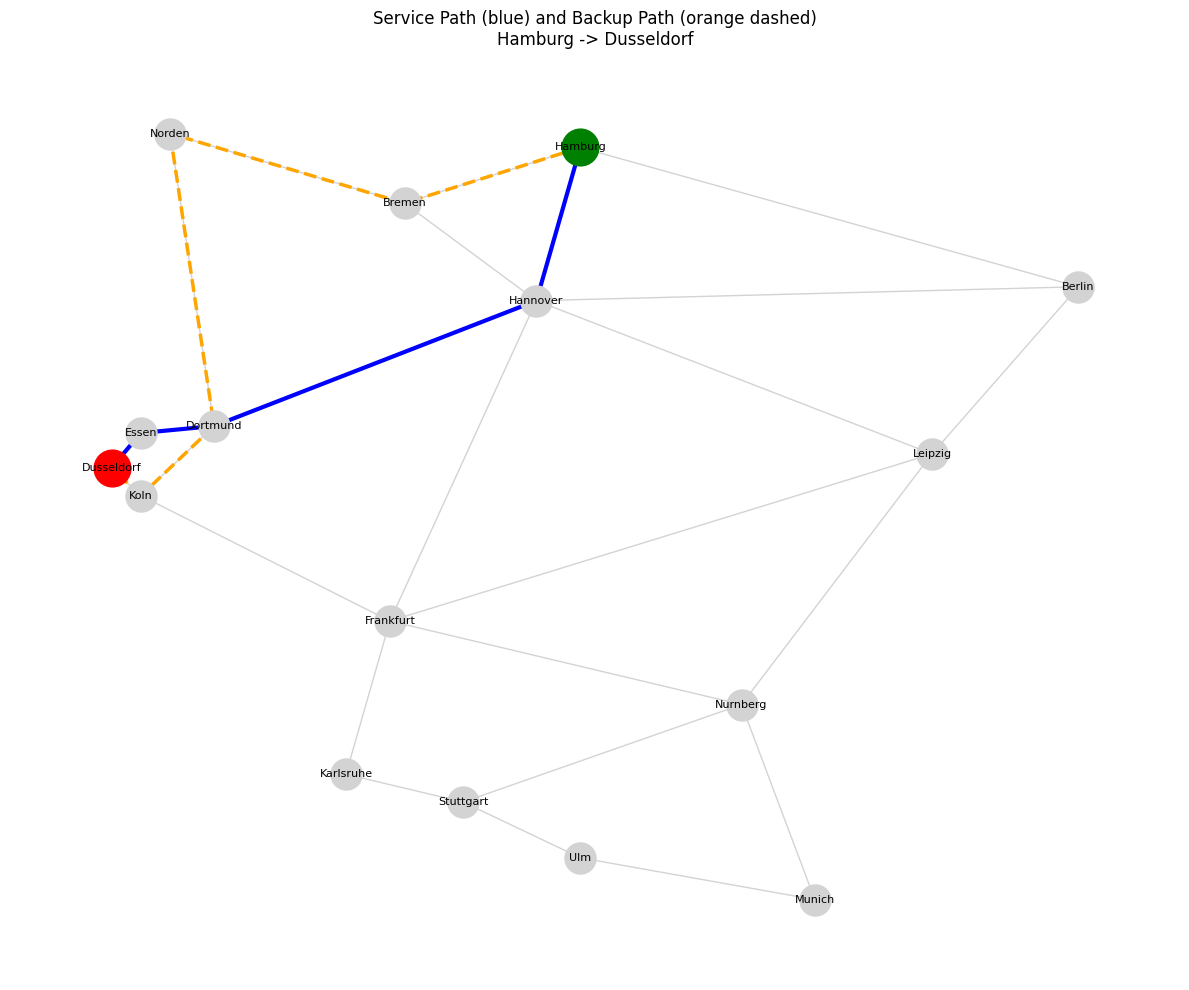

In [934]:
# Visualize service and backup paths
fig, ax = plt.subplots(figsize=(12, 10))

# Draw base network
nx.draw_networkx_nodes(G_name, pos, node_color='lightgray', node_size=500, ax=ax)
nx.draw_networkx_edges(G_name, pos, edge_color='lightgray', width=1, ax=ax)
nx.draw_networkx_labels(G_name, pos, font_size=8, ax=ax)

X_NODE = "Hamburg"
Y_NODE = "Dusseldorf" 

# Highlight X and Y
nx.draw_networkx_nodes(G_name, pos, nodelist=[X_NODE], node_color='green', node_size=700, ax=ax)
nx.draw_networkx_nodes(G_name, pos, nodelist=[Y_NODE], node_color='red', node_size=700, ax=ax)

# Draw service path (blue solid)
service_edge_list = [(service_path_names[i], service_path_names[i+1]) for i in range(len(service_path_names)-1)]
nx.draw_networkx_edges(G_name, pos, edgelist=service_edge_list, edge_color='blue', width=3, ax=ax)

# Draw first edge-disjoint backup path (orange dashed)
for path in k_paths[1:]:
    path_edges = set(frozenset([path[j], path[j+1]]) for j in range(len(path)-1))
    if len(path_edges & service_edges) == 0:
        backup_edge_list = [(path[i], path[i+1]) for i in range(len(path)-1)]
        nx.draw_networkx_edges(G_name, pos, edgelist=backup_edge_list, 
                              edge_color='orange', width=2.5, style='dashed', ax=ax)
        break

ax.set_title(f"Service Path (blue) and Backup Path (orange dashed)\n{X_NODE} -> {Y_NODE}")
ax.axis('off')
plt.tight_layout()
plt.savefig('phase2f_paths.png', dpi=150)
plt.show()

In [935]:
# Third phase

# Group 10 specific parameters
X = 29 # Gb/s
Y = 49 # Gb/s
Z = 51 # Gb/s

# 1) Traffic Matrix & Demand Matrix

idx_to_num = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17]

idxs = [1,2,3,4,5,6,7,8,10,11,13,14,15,17] # indx from traffic mat to node number

raw_traffic = np.array(([0, X, Y, Z, X, Y, 0, X, Y, 0, X, 0, 0, 0],
                        [X, 0, X, Y, 0, X, 0, Z, X, Y, Z, 0, 0, Z],
                        [Y, X, 0, X, Y, 0, X, 0, Z, X, 0, Z, 0, 0],
                        [Z, Y, X, 0, X, Y, Z, 0, 0, Z, X, 0, Z, 0],
                        [X, 0, Y, X, 0, X, Y, Z, 0, Y, 0, 0, 0, Z],
                        [Y, X, 0, Y, X, 0, X, Y, Z, X, Y, 0, X, 0],
                        [0, 0, X, Z, Y, X, 0, X, Y, Z, X, 0, Z, X],
                        [X, Z, 0, 0, Z, Y, X, 0, X, Y, Z, X, 0, Z],
                        [Y, X, Z, 0, 0, Z, Y, X, 0, X, Y, Z, X, Y],
                        [0, Y, X, Z, Y, X, Z, Y, X, 0, X, Y, Z, X],
                        [X, Z, 0, X, 0, Y, X, Z, Y, X, 0, X, Y, Z],
                        [0, 0, Z, 0, 0, 0, 0, X, Z, Y, X, 0, X, Y],
                        [0, 0, 0, Z, 0, X, Z, 0, X, Z, Y, X, 0, X],
                        [0, Z, 0, 0, Z, 0, X, Z, Y, X, Z, Y, X, 0]))


size = 17

helper = np.zeros((size,size)) # Contains all city numbers
traffic_mat = np.zeros((size-1,size-1)) # Mannheim (12) removed 
demand_mat = np.zeros((size-1,size-1)) # Mannheim (12) removed

idx_to_number = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

for i, row in enumerate(raw_traffic):
    real_i = idxs[i] - 1
    for j, val in enumerate(row):
        real_j = idxs[j] - 1
        helper[real_i][real_j] = val

magic = 11
for i, row in enumerate(helper):
    for j, val in enumerate(row):
        if i < magic and j < magic:
            traffic_mat[i][j] = val
            if helper[i][j] != 0:
                demand_mat[i][j] = 1
        elif i > magic and j < magic:
            traffic_mat[i-1][j] = helper[i][j]
            if helper[i][j] != 0:
                demand_mat[i-1][j] = 1
        elif i < magic and j > magic:
            traffic_mat[i][j-1] = helper[i][j]
            if helper[i][j] != 0:
                demand_mat[i][j-1] = 1
        elif i > magic and j > magic:
            traffic_mat[i-1][j-1] = helper[i][j]
            if helper[i][j] != 0:
                demand_mat[i-1][j-1] = 1



# Nullify lower half of demand matrix
for i , row in enumerate(demand_mat):
    for j, val in enumerate(row):
        if j <= i:
            demand_mat[i][j] = 0
            # traffic_mat[i][j] = 0

In [ ]:
# Unweighted routing
relevant_path = []

# Take only relevant paths into consideration: only those pairs that have a demand between them
for i, row in enumerate(paths_unweighted):
    for j, path in enumerate(row):
        src, dst = path["source"] - 1, path["destination"] - 1 # Convert numbers from adj. matrix format --> traffic matrix format
        if demand_mat[src][dst] == 1:
            relevant_path.append(path)

distances = []

# Extract distance metric
for path in relevant_path:
    v1 = path["source"]
    v2 = path["destination"]
    v3 = path["distance"]
    v4 = path["path"]
    distances.append(v3)

# convert to numpy
relevant_path = np.array(relevant_path)
distances = np.array(distances)

# sort distances
sort_ind = np.argsort(distances)

# shortest first order
shortest_first = relevant_path[sort_ind]

# longest first order
longest_first = shortest_first[::-1]

found: {'source': 1, 'destination': 2, 'distance': 1, 'path': [[1, 2]]}
found: {'source': 1, 'destination': 3, 'distance': 2, 'path': [[1, 2, 3]]}
found: {'source': 1, 'destination': 4, 'distance': 2, 'path': [[1, 2, 4], [1, 16, 4]]}
found: {'source': 1, 'destination': 5, 'distance': 3, 'path': [[1, 2, 3, 5], [1, 16, 4, 5], [1, 2, 4, 5]]}
found: {'source': 1, 'destination': 6, 'distance': 3, 'path': [[1, 2, 4, 6], [1, 16, 4, 6]]}
found: {'source': 1, 'destination': 8, 'distance': 5, 'path': [[1, 2, 4, 6, 7, 8], [1, 16, 4, 6, 7, 8], [1, 2, 4, 12, 7, 8], [1, 16, 4, 12, 7, 8], [1, 16, 13, 12, 7, 8]]}
found: {'source': 1, 'destination': 10, 'distance': 5, 'path': [[1, 2, 4, 6, 7, 10], [1, 16, 4, 6, 7, 10], [1, 2, 4, 12, 7, 10], [1, 2, 4, 12, 11, 10], [1, 16, 4, 12, 7, 10], [1, 16, 13, 12, 7, 10], [1, 16, 4, 12, 11, 10], [1, 16, 13, 12, 11, 10]]}
found: {'source': 1, 'destination': 12, 'distance': 3, 'path': [[1, 2, 4, 12], [1, 16, 4, 12], [1, 16, 13, 12]]}


In [ ]:
for path in shortest_first:
    src, dst, path = path["source"], path["destination"], path["path"]
    if len(path) >= 1:
        take_path = path[0]
        for i, v in enumerate(take_path):
            if i > 0:
                v1, v2 = take_path[i-1], v # (v1, v2) is a vertice pair as in adjancy matrix
                gv1, gv2 = v1, v2          # (gv1, gv2) are the vertice pair NUMBERS as in the graph G_num
                if v1 >= 12:
                    gv1 +=1
                if v2 >= 12:
                    gv2 +=1
                
                old = G_cap.edges[gv1, gv2]["load"] # Find existing load
                new = old + traffic_mat[src-1][dst-1] # Calculate new load
                attr = {(gv1,gv2): {"load": new}}
                nx.set_edge_attributes(G_cap,attr)  # Add load


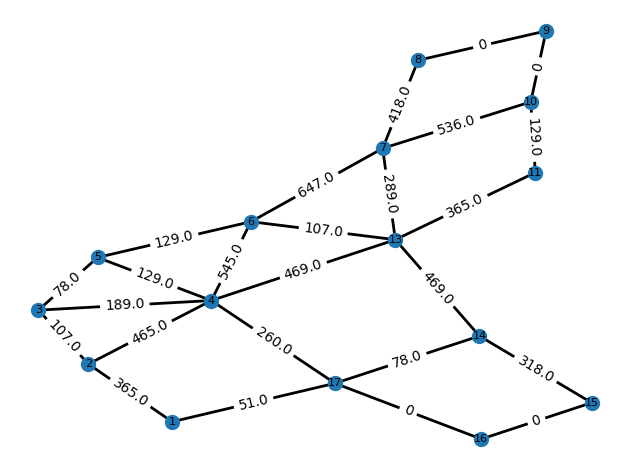

In [939]:
# DRAWING of the graph with city names

pos = nx.spring_layout(G_cap, seed=10)
# nodes
nx.draw_networkx_nodes(G_cap, pos, node_size=100)

# edges
nx.draw_networkx_edges(G_cap, pos, edgelist=G_cap.edges, width=2)

# node labels
nx.draw_networkx_labels(G_cap, pos, font_size=8, font_family="sans-serif")

# edge labels
# edge_lengths = nx.get_edge_attributes(G_cap, "length") # Edge weights/lengths AKA the direct path distances between cities
edge_capacities = nx.get_edge_attributes(G_cap, "load") # Capacities of the links
edge_labels = {} # Combination of lenghts and capacities 


nx.draw_networkx_edge_labels(G_cap, pos, edge_capacities) 

ax = plt.gca()
ax.margins(0.00115)
plt.axis("off")
plt.tight_layout()
plt.show()